In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binom, poisson, geom
import math
import matplotlib.pyplot as plt
import timeit
from scipy.stats import linregress
from scipy.special import factorial
from itertools import combinations

class Network ( object ) :
    def __init__ ( self , num_nodes ) :
        self . adj = { i :set () for i in range ( num_nodes ) }

    def add_edge ( self , i , j ) :
        self . adj [ i ]. add ( j )
        self . adj [ j ]. add ( i )

    def neighbors ( self , i ) :
        return self . adj [ i ]

    def edge_list ( self ) :    
        return [( i , j ) for i in self . adj for j in self . adj [ i ] if i < j ]

In [2]:
def generate_edge_list (k):
#n is the number of nodes, k is the degree distribution ( a list where k[i] is)
#the degree of node i)
    n = len ( k )
    S = np.array ([ i for i in range ( n ) for _ in range ( k [ i ]) ])
    S = np.random.permutation ( S )
    if len ( S ) % 2:
        S = S [: -1]
    S = S . reshape ( -1 , 2)
    return S

In [3]:
def to_array(edges):
    if isinstance(edges, list):
        if len(edges) == 0:
            return np.empty((0, 2), dtype=int)
        else:
            return np.array(edges)
    return edges

In [46]:
def generate_H():
    n = 150000
    s = 25000
    k_max = 1000

    #Homogenous network - mean = 6
    k = np.zeros (n, dtype=int)
    for i in range(n):
        k[i] = np.random.geometric(1/7)-1

    k = np.clip(k, None, k_max)

    S = generate_edge_list(k)
    H = Network(n)
    for i, j in S:
            H.add_edge(i, j)
    return H

def generate_I(student_mean, interconnections):
    #Control student mean and interconnections, but within non-students: families of 5, each with a mean of 10 edges leaving the family. 
    n = 150000
    s = 25000
    k_max = 1000
    p = 1/(student_mean+1)
    k_students = np.random.geometric(p, size=s)
    k_students = k_students - 1
    k_students = np.clip(k_students, None, k_max)
    S_edges = generate_edge_list(k_students)

    #family edges
    F_edges = []
    for i in range((n-s)//5):
        parent = i * 5
        family = (parent, parent + 1, parent + 2, parent + 3, parent + 4)
        pairs = list(combinations(family, 2))
        F_edges.extend(pairs)
    F_edges_shifted = [(i + s, j + s) for i, j in F_edges]

    #interfamily edges
    k_non_students = np.random.poisson(1, size=n - s)
    k_non_students = np.clip(k_non_students, None, k_max)
    N_edges = generate_edge_list(k_non_students)
    N_edges_shifted = [(i + s, j + s) for i, j in N_edges]
    
    num_edges_per_student = np.random.poisson(interconnections, size=s)
    student_nodes = np.repeat(np.arange(s), num_edges_per_student)
    num_inter = len(student_nodes)

    targets = np.random.randint(s, n, size=num_inter)
    inter_edges = np.stack([student_nodes, targets], axis=1)

    S_edges = to_array(S_edges)
    N_edges_shifted = to_array(N_edges_shifted)
    F_edges_shifted = to_array(F_edges_shifted)
    inter_edges = to_array(inter_edges)

    all_edges = np.vstack((S_edges, N_edges_shifted, F_edges_shifted, inter_edges)) #- use if allowing interfamily edges
    #all_edges = np.vstack((S_edges, F_edges_shifted, inter_edges))
        
    I = Network(n)
    for i, j in all_edges:
        I.add_edge(i, j)   

    return I

Vaccinate all before running

In [16]:
def run_week(S, I, R, D, G, λ, μ, s):
    R_copy = R.copy()
    S_copy = S.copy()
    I_copy = I.copy()
    D_copy = D.copy()


    for i in I:
        for j in G.neighbors(i):
            if j in S_copy:
                if np.random.uniform(0, 1) < λ:
                    S_copy.remove(j)
                    I_copy.add(j)
        if i >= s and np.random.uniform(0, 1) < μ:
            D_copy.add(i)
            I_copy.remove(i)    
        else:
            I_copy.remove(i)
            R_copy.add(i)

    S = S_copy
    I = I_copy
    R = R_copy
    D = D_copy


    return S, I, R, D

In [21]:
def simulation_setup (n, s, starting_infected, starting_vaccinated, method = 'random'):
    #pick starting fraction in I
    p_0 = starting_infected * n
    #Pick starting fraction vaccinated
    v_0 = starting_vaccinated * n
    
    if method == 'random':
        V = set()
        for i in range(int(v_0)):
            k = np.random.randint(0, n)
            while k in V:
                k = np.random.randint(0, n)
            V.add(k)
    elif method == 'student':
        V = set()
        for i in range(int(v_0)):
            k = np.random.randint(0, s)
            while k in V:
                k = np.random.randint(0, s)
            V.add(k)
    elif method == 'non_student':
        V = set()
        for i in range(int(v_0)):
            k = np.random.randint(s, n)
            while k in V:
                k = np.random.randint(s, n)
            V.add(k)
    
        #randomly pick starting nodes
    I_0 = set()
    for i in range(int(p_0)):
        k = np.random.randint(0, n)
        while k in I_0 or k in V:
            k = np.random.randint(0, n)
        I_0.add(k)

    R_0 = set()
    D_0 = set()

    S_0 = set()
    for i in range(n):
        if i not in I_0 and i not in V:
            S_0.add(i)

    return S_0, I_0, R_0, D_0

In [18]:
def run_simulation (G, I_0, R_0, S_0, D_0, λ, μ, s, weeks):
    Susceptible = []
    Infectious = []
    Recovered = []
    Deceased = []

    Susceptible.append(len(S_0))
    Infectious.append(len(I_0))
    Recovered.append(len(R_0))
    Deceased.append(len(D_0))

    for i in range(weeks):
        S_0, I_0, R_0, D_0 = run_week(S_0, I_0, R_0, D_0, G, λ, μ, s)
        Susceptible.append(len(S_0))
        Infectious.append(len(I_0))
        Recovered.append(len(R_0))
        Deceased.append(len(D_0))

    return Deceased

In [81]:
random_vacc = []
student_vacc = []
non_student_vacc = []
n =150000
s = 25000
μ = 0.01
weeks = 100

lambdas = np.linspace(0, 1, 10)

v_range = ['random', 'student', 'non_student']
I = generate_I(10, 10)
for v in v_range:
    print(v)
    for λ in lambdas:
        print(λ)
        S_0, I_0, R_0, D_0 = simulation_setup(n, s, 0.001, (1/6), v)
        Deceased = run_simulation(I, I_0, R_0, S_0, D_0, λ, μ, s, weeks)
        if v == 'random':
            random_vacc.append(Deceased[-1])
        if v == 'student':
            student_vacc.append(Deceased[-1])
        if v == 'non_student':
            non_student_vacc.append(Deceased[-1])


plt.figure(figsize=(10,6))
plt.plot(lambdas, random_vacc, label='0% Vaccinated', marker='o')
plt.plot(lambdas, student_vacc, label='20% Vaccinated', marker='s')
plt.plot(lambdas, non_student_vacc, label='40% Vaccinated', marker='^')
plt.xlabel('Infection Probability λ')
plt.ylabel('Final Number Recovered')
plt.title('Impact of Vaccination Rate on Final Epidemic Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

random
0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556


KeyboardInterrupt: 

random
0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0
student
0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0
non_student
0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


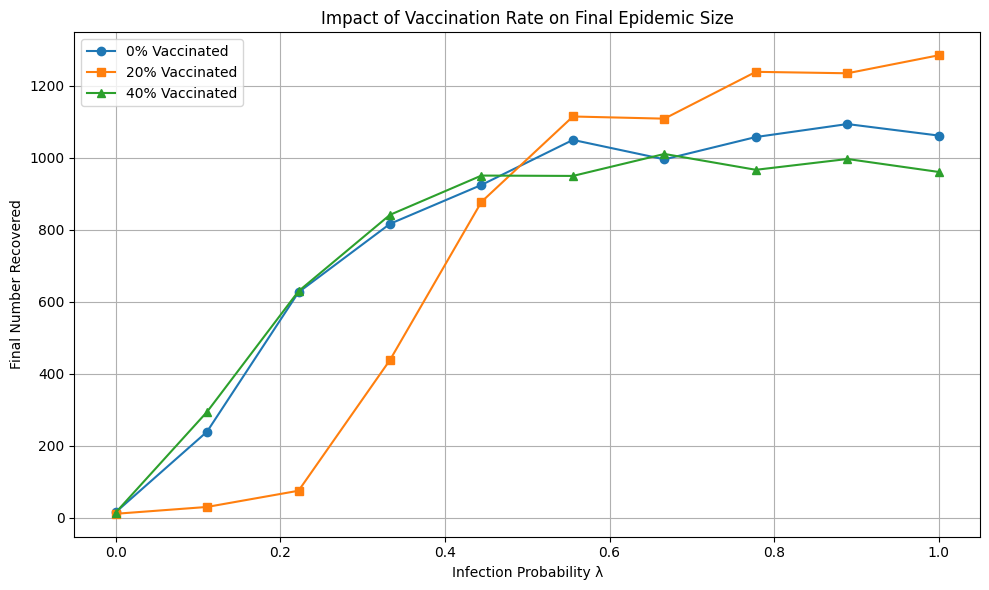

In [ ]:
random_vacc = []
student_vacc = []
non_student_vacc = []
n =150000
s = 25000
μ = 0.01
weeks = 100

lambdas = np.linspace(0, 1, 10)

v_range = ['random', 'student', 'non_student']
I = generate_I(30, 10)
for v in v_range:
    print(v)
    for λ in lambdas:
        print(λ)
        S_0, I_0, R_0, D_0 = simulation_setup(n, s, 0.001, (1/6), v)
        Deceased = run_simulation(I, I_0, R_0, S_0, D_0, λ, μ, s, weeks)
        if v == 'random':
            random_vacc.append(Deceased[-1])
        if v == 'student':
            student_vacc.append(Deceased[-1])
        if v == 'non_student':
            non_student_vacc.append(Deceased[-1])


plt.figure(figsize=(10,6))
plt.plot(lambdas, random_vacc, label='0% Vaccinated', marker='o')
plt.plot(lambdas, student_vacc, label='20% Vaccinated', marker='s')
plt.plot(lambdas, non_student_vacc, label='40% Vaccinated', marker='^')
plt.xlabel('Infection Probability λ')
plt.ylabel('Final Number Recovered')
plt.title('Impact of Vaccination Rate on Final Epidemic Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
def generate_H():
    n = 150000
    s = 25000
    k_max = 1000

    #Homogenous network - mean = 6
    k = np.zeros (n, dtype=int)
    for i in range(n):
        k[i] = np.random.geometric(1/7)-1

    k = np.clip(k, None, k_max)

    S = generate_edge_list(k)
    H = Network(n)
    for i, j in S:
            H.add_edge(i, j)
    return H

def generate_I(student_mean, interconnections):
    #Control student mean and interconnections, but within non-students: families of 5, each with a mean of 10 edges leaving the family. 
    n = 150000
    s = 25000
    k_max = 1000
    p = 1/(student_mean+1)
    k_students = np.random.geometric(p, size=s)
    k_students = k_students - 1
    k_students = np.clip(k_students, None, k_max)
    S_edges = generate_edge_list(k_students)

    #family edges
    F_edges = []
    for i in range((n-s)//5):
        parent = i * 5
        family = (parent, parent + 1, parent + 2, parent + 3, parent + 4)
        pairs = list(combinations(family, 2))
        F_edges.extend(pairs)
    F_edges_shifted = [(i + s, j + s) for i, j in F_edges]

    #interfamily edges
    k_non_students = np.random.poisson(1, size=n - s)
    k_non_students = np.clip(k_non_students, None, k_max)
    N_edges = generate_edge_list(k_non_students)
    N_edges_shifted = [(i + s, j + s) for i, j in N_edges]
    
    num_edges_per_student = np.random.poisson(interconnections, size=s)
    student_nodes = np.repeat(np.arange(s), num_edges_per_student)
    num_inter = len(student_nodes)

    targets = np.random.randint(s, n, size=num_inter)
    inter_edges = np.stack([student_nodes, targets], axis=1)

    S_edges = to_array(S_edges)
    N_edges_shifted = to_array(N_edges_shifted)
    F_edges_shifted = to_array(F_edges_shifted)
    inter_edges = to_array(inter_edges)

    all_edges = np.vstack((S_edges, N_edges_shifted, F_edges_shifted, inter_edges)) #- use if allowing interfamily edges
    #all_edges = np.vstack((S_edges, F_edges_shifted, inter_edges))
        
    I = Network(n)
    for i, j in all_edges:
        I.add_edge(i, j)   

    return I

random
0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004
0.325
0.35000000000000003
0.375
0.4
0.42500000000000004
0.45
0.47500000000000003
0.5
student
0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004
0.325
0.35000000000000003
0.375
0.4
0.42500000000000004
0.45
0.47500000000000003
0.5
non_student
0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004
0.325
0.35000000000000003
0.375
0.4
0.42500000000000004
0.45
0.47500000000000003
0.5


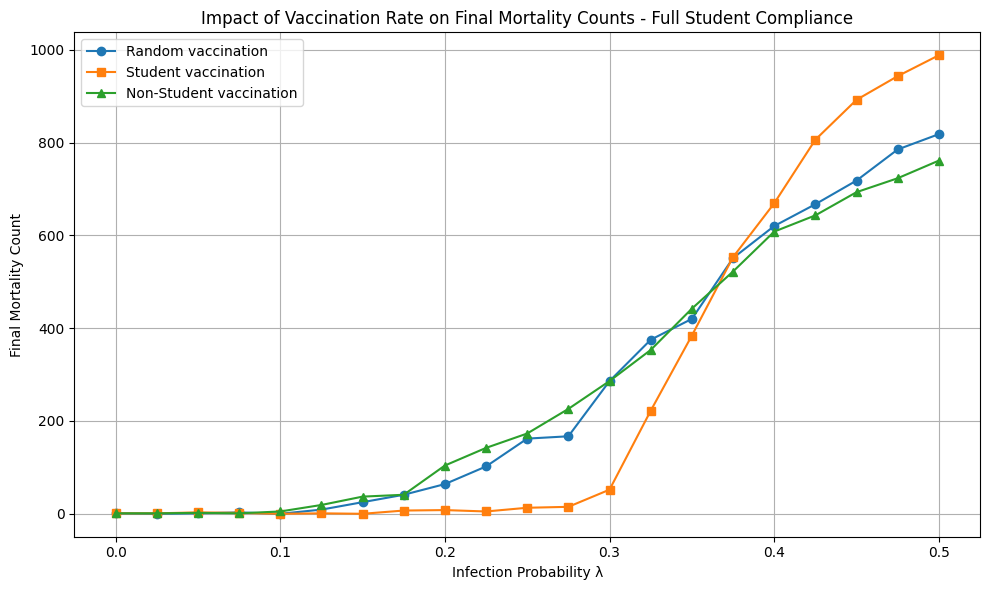

In [83]:
random_vacc = []
student_vacc = []
non_student_vacc = []
n =150000
s = 25000
μ = 0.01
weeks = 100

lambdas = np.linspace(0, 0.5, 21)

v_range = ['random', 'student', 'non_student']
I = generate_I(5, 2)
for v in v_range:
    print(v)
    for λ in lambdas:
        print(λ)
        S_0, I_0, R_0, D_0 = simulation_setup(n, s, 0.001, (1/6), v)
        Deceased = run_simulation(I, I_0, R_0, S_0, D_0, λ, μ, s, weeks)
        if v == 'random':
            random_vacc.append(Deceased[-1])
        if v == 'student':
            student_vacc.append(Deceased[-1])
        if v == 'non_student':
            non_student_vacc.append(Deceased[-1])


plt.figure(figsize=(10,6))
plt.plot(lambdas, random_vacc, label='Random vaccination', marker='o')
plt.plot(lambdas, student_vacc, label='Student vaccination', marker='s')
plt.plot(lambdas, non_student_vacc, label='Non-Student vaccination', marker='^')
plt.xlabel('Infection Probability λ')
plt.ylabel('Final Mortality Count')
plt.title('Impact of Vaccination Rate on Final Mortality Counts - Full Student Compliance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

random
0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004
0.325
0.35000000000000003
0.375
0.4
0.42500000000000004
0.45
0.47500000000000003
0.5
student
0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004
0.325
0.35000000000000003
0.375
0.4
0.42500000000000004
0.45
0.47500000000000003
0.5
non_student
0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004
0.325
0.35000000000000003
0.375
0.4
0.42500000000000004
0.45
0.47500000000000003
0.5


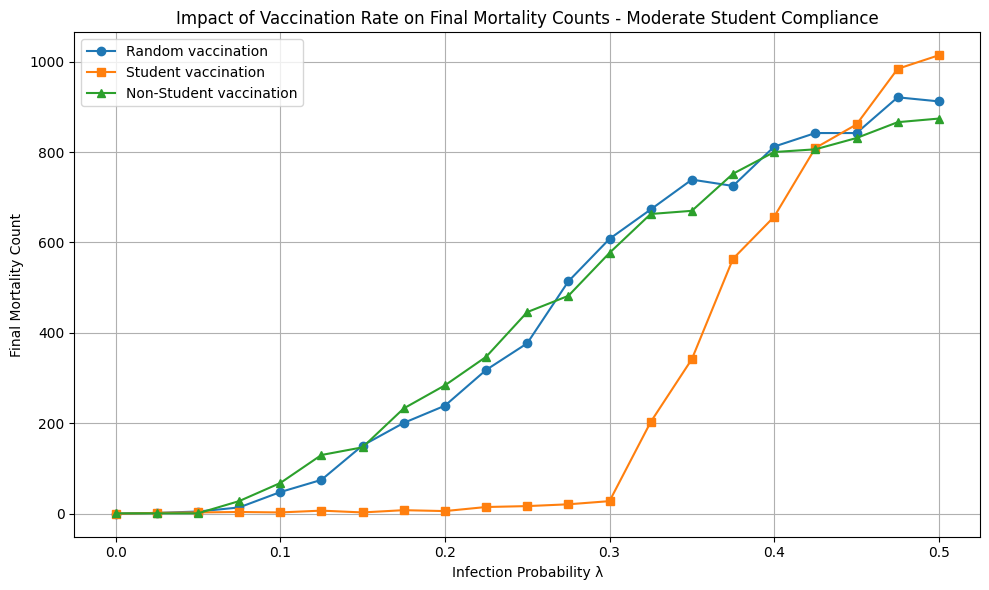

In [84]:
random_vacc = []
student_vacc = []
non_student_vacc = []
n =150000
s = 25000
μ = 0.01
weeks = 100

lambdas = np.linspace(0, 0.5, 21)

v_range = ['random', 'student', 'non_student']
I = generate_I(10, 5)
for v in v_range:
    print(v)
    for λ in lambdas:
        print(λ)
        S_0, I_0, R_0, D_0 = simulation_setup(n, s, 0.001, (1/6), v)
        Deceased = run_simulation(I, I_0, R_0, S_0, D_0, λ, μ, s, weeks)
        if v == 'random':
            random_vacc.append(Deceased[-1])
        if v == 'student':
            student_vacc.append(Deceased[-1])
        if v == 'non_student':
            non_student_vacc.append(Deceased[-1])


plt.figure(figsize=(10,6))
plt.plot(lambdas, random_vacc, label='Random vaccination', marker='o')
plt.plot(lambdas, student_vacc, label='Student vaccination', marker='s')
plt.plot(lambdas, non_student_vacc, label='Non-Student vaccination', marker='^')
plt.xlabel('Infection Probability λ')
plt.ylabel('Final Mortality Count')
plt.title('Impact of Vaccination Rate on Final Mortality Counts - Moderate Student Compliance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

random
0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004
0.325
0.35000000000000003
0.375
0.4
0.42500000000000004
0.45
0.47500000000000003
0.5
student
0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004
0.325
0.35000000000000003
0.375
0.4
0.42500000000000004
0.45
0.47500000000000003
0.5
non_student
0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004
0.325
0.35000000000000003
0.375
0.4
0.42500000000000004
0.45
0.47500000000000003
0.5


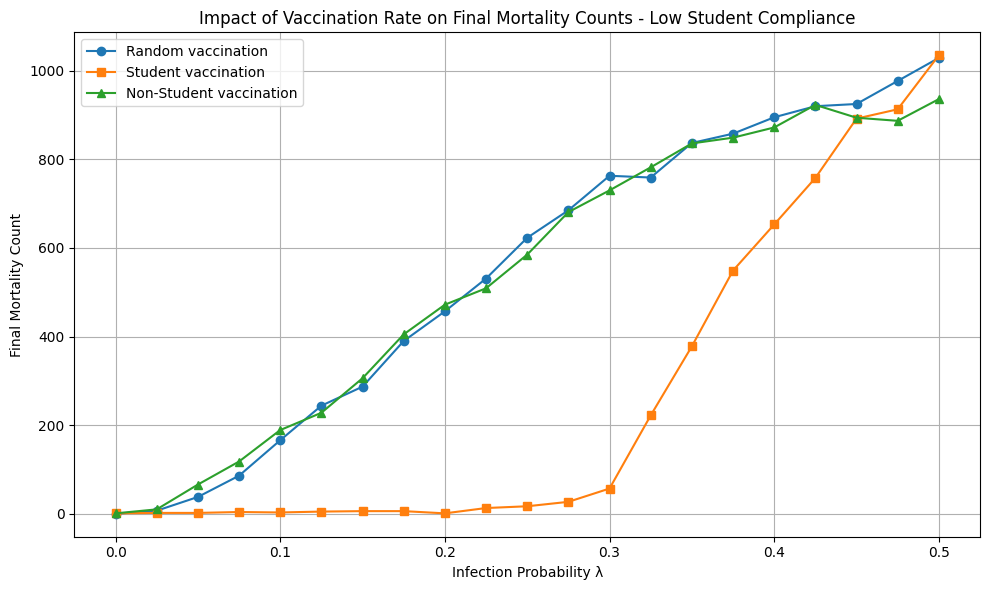

In [85]:
random_vacc = []
student_vacc = []
non_student_vacc = []
n =150000
s = 25000
μ = 0.01
weeks = 100

lambdas = np.linspace(0, 0.5, 21)

v_range = ['random', 'student', 'non_student']
I = generate_I(30, 8)
for v in v_range:
    print(v)
    for λ in lambdas:
        print(λ)
        S_0, I_0, R_0, D_0 = simulation_setup(n, s, 0.001, (1/6), v)
        Deceased = run_simulation(I, I_0, R_0, S_0, D_0, λ, μ, s, weeks)
        if v == 'random':
            random_vacc.append(Deceased[-1])
        if v == 'student':
            student_vacc.append(Deceased[-1])
        if v == 'non_student':
            non_student_vacc.append(Deceased[-1])


plt.figure(figsize=(10,6))
plt.plot(lambdas, random_vacc, label='Random vaccination', marker='o')
plt.plot(lambdas, student_vacc, label='Student vaccination', marker='s')
plt.plot(lambdas, non_student_vacc, label='Non-Student vaccination', marker='^')
plt.xlabel('Infection Probability λ')
plt.ylabel('Final Mortality Count')
plt.title('Impact of Vaccination Rate on Final Mortality Counts - Low Student Compliance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()